https://neptune.ai/blog/select-model-for-time-series-prediction-task

https://towardsdatascience.com/anomaly-detection-in-time-series-sensor-data-86fd52e62538

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots

(-2.8521928674859875, 0.05119645398394443, 7, 404, {'1%': -3.44664043608676, '5%': -2.868720756230461, '10%': -2.5705951311145965}, 3228.473547813319)
(-7.365208071233204, 9.275152391668611e-11, 7, 403, {'1%': -3.4466811208382437, '5%': -2.8687386420385494, '10%': -2.5706046655665635}, 3227.061876006187)


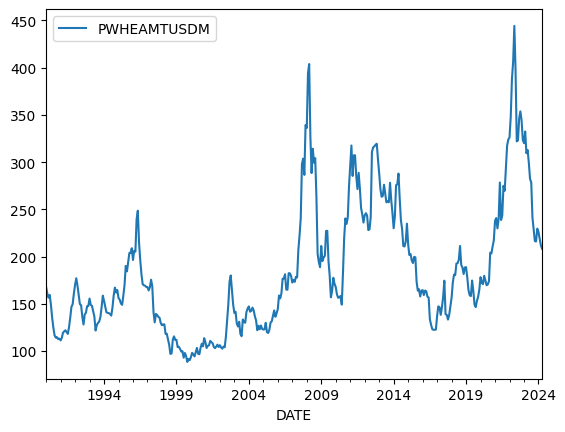

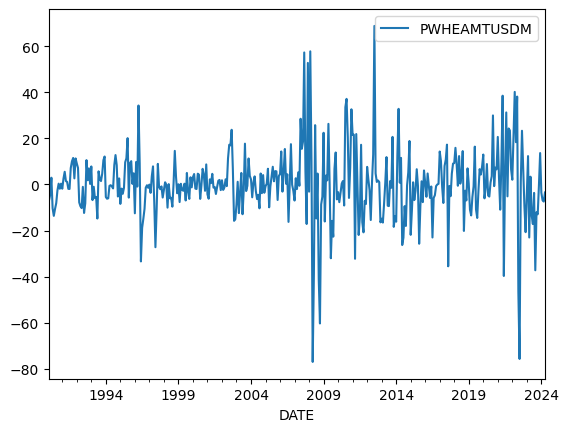

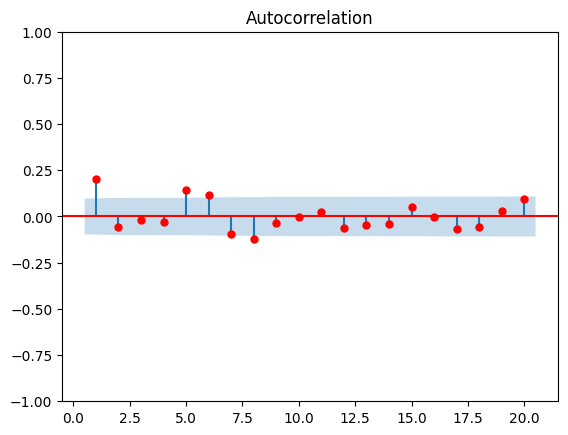

In [172]:
data = pd.read_csv('PWHEAMTUSDM.csv', parse_dates=True, index_col=0)

data.plot()

print(adfuller(data))

data = data.diff().dropna()
data.plot()
print(adfuller(data))
fig = tsaplots.plot_acf(data, color='r', lags=20, zero=False)
plt.show()

Now the data is stationary and has no autocorelation.

We'll use 3 algorithms to detect anomalies:

1. Benchamark model: Interquartile Range (IQR)
2. K-Means clustering
3. Isolation forest

1. IQR

In [173]:
q1_data, q3_data = data['PWHEAMTUSDM'].quantile([0.25, 0.75])
iqr_data = q3_data - q1_data

lower_bound = q1_data - 1.5 * iqr_data
upper_bound = q3_data + 1.5 * iqr_data

print(lower_bound, upper_bound)

-25.307925014104 25.744288002240012


Filtering out outliers

In [174]:
data['anomaly1'] = ((data>upper_bound) | (data<lower_bound)).astype(int)


Plotting

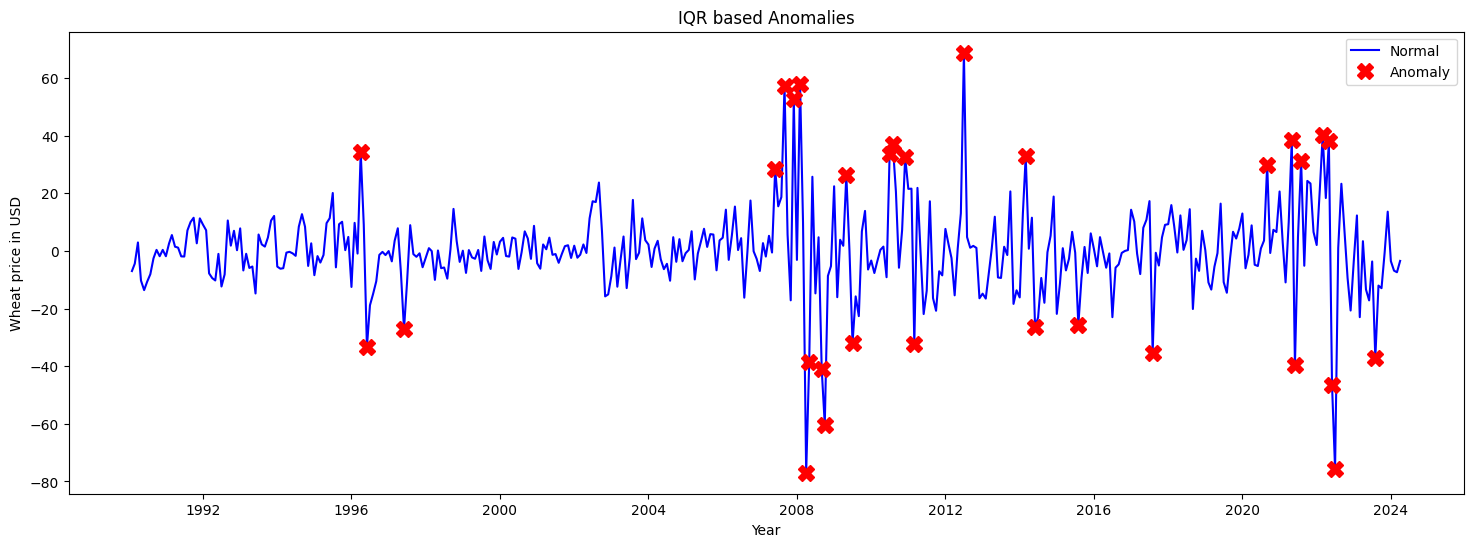

In [175]:
a = data[data['anomaly1'] == 1] #anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(data['PWHEAMTUSDM'], color='blue', label='Normal')
_ = plt.plot(a['PWHEAMTUSDM'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
_ = plt.xlabel('Year')
_ = plt.ylabel('Wheat price in USD')
_ = plt.title('IQR based Anomalies')
_ = plt.legend(loc='best')
plt.show()

2.1. K-means Clustering

In [176]:
from sklearn.cluster import KMeans

In [177]:
n_clusters_list = [1, 2, 3, 4, 5]

In [178]:
#function which calculates distance between each point and the centroid of the closest cluster

def getDistanceBetweenPointsAndCentroid(data, model):
  distance = []
  data_indeces_as_ints = data.reset_index(drop=True)
  for i in data_indeces_as_ints.index:
    Xa = np.array(data_indeces_as_ints.loc[i])
    Xb = model.cluster_centers_[model.labels_[i]-1]
    distance.append(np.linalg.norm(Xa-Xb))
  return pd.Series(distance, index=data.index)

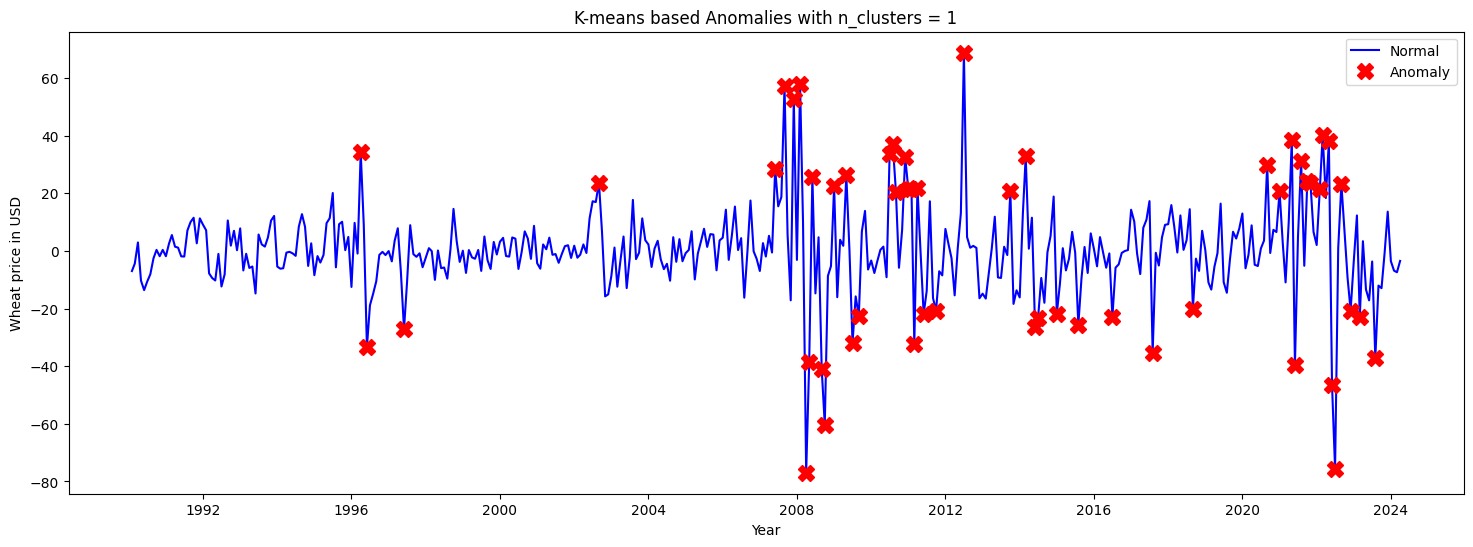

Anomalies detected:  53


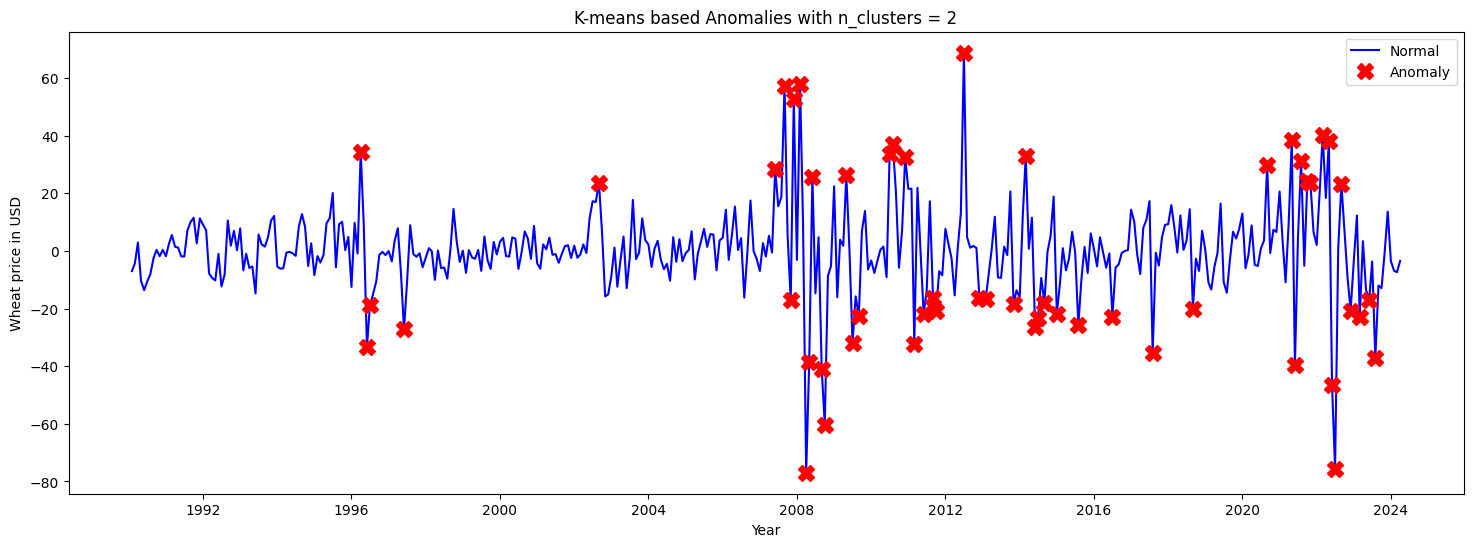

Anomalies detected:  53


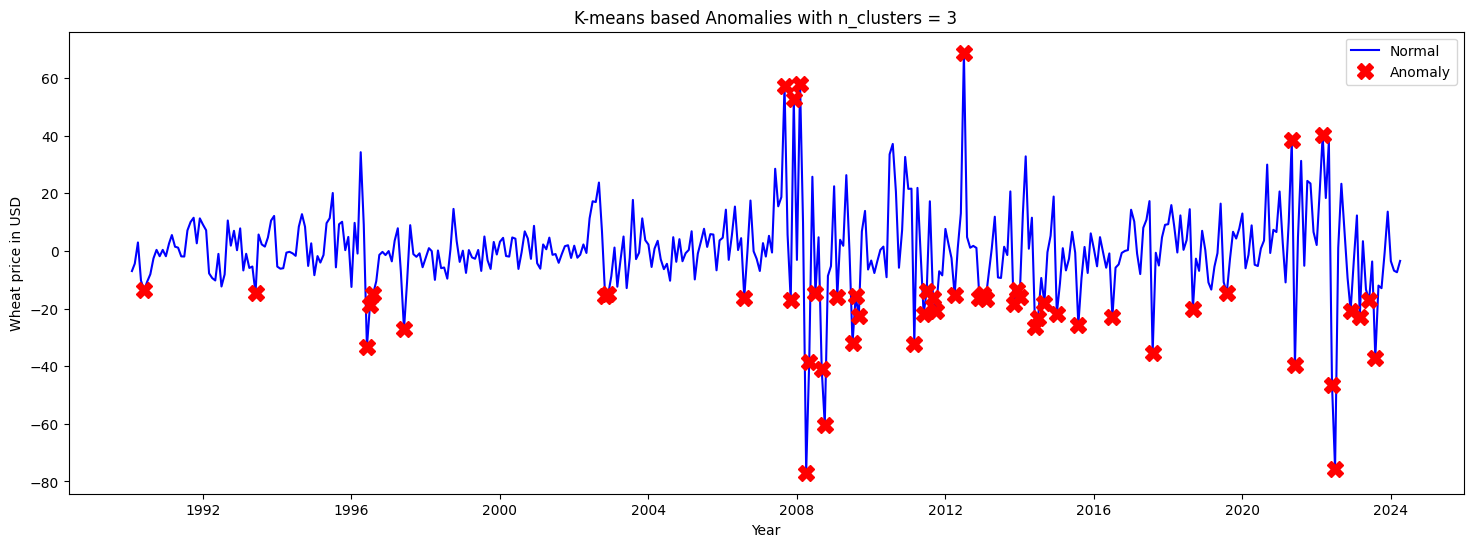

Anomalies detected:  53


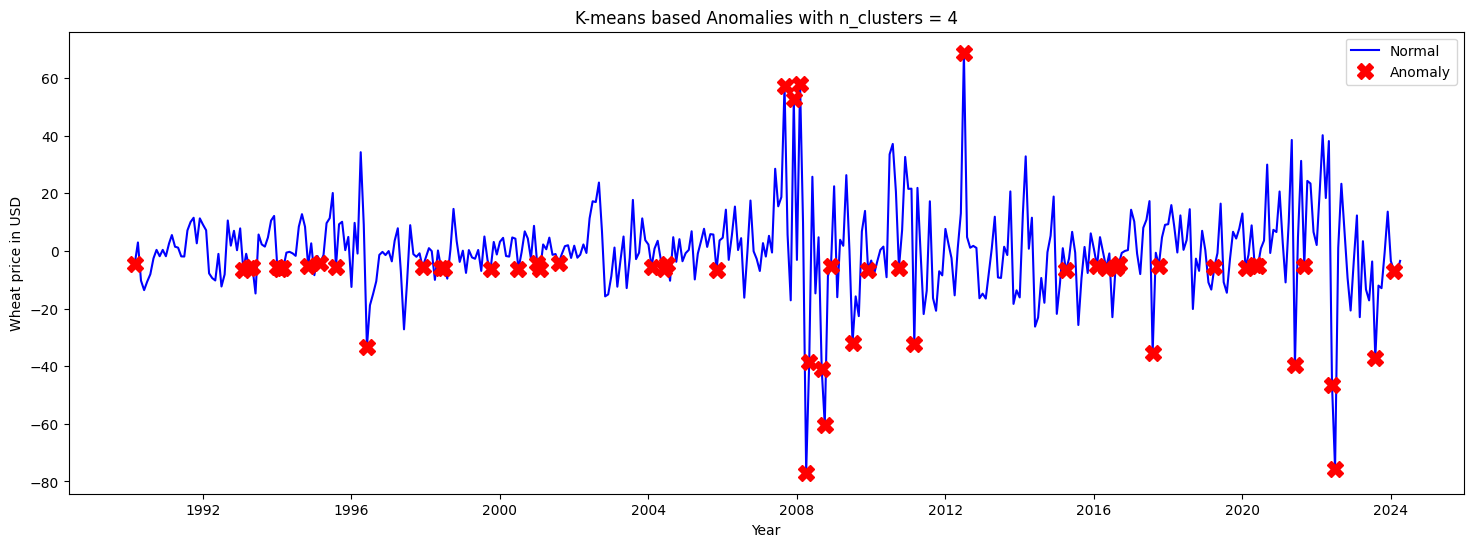

Anomalies detected:  53


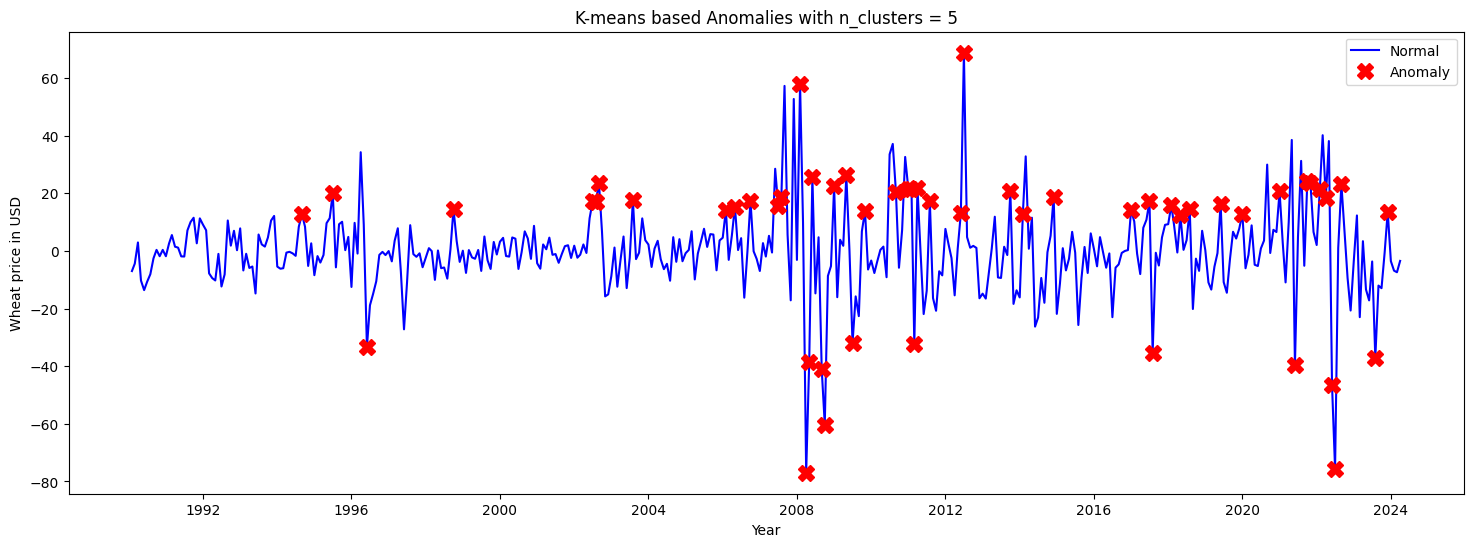

Anomalies detected:  53


In [179]:
# this value has to be tuned 
outliers_fractions = 0.13

for k in n_clusters_list:
  kmean = KMeans(n_clusters=k, random_state=42).fit(data.values)
  label = kmean.predict(data.values)
  unique_elements, counts_elements = np.unique(label, return_counts=True)
  clusters = np.asarray((unique_elements, counts_elements))

  distance = getDistanceBetweenPointsAndCentroid(data, kmean)

  number_of_outliers = int(outliers_fractions*len(distance))

  threshold_distance = distance.nlargest(number_of_outliers).min()

  data[f'anomaly2_kmeans${kmean}'] = (distance >= threshold_distance).astype(int)
  a = data[data[f'anomaly2_kmeans${kmean}'] == 1] #anomaly
  _ = plt.figure(figsize=(18,6))
  _ = plt.plot(data['PWHEAMTUSDM'], color='blue', label='Normal')
  _ = plt.plot(a['PWHEAMTUSDM'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
  _ = plt.xlabel('Year')
  _ = plt.ylabel('Wheat price in USD')
  _ = plt.title(f'K-means based Anomalies with n_clusters = {k}')
  _ = plt.legend(loc='best')
  plt.show()
  print('Anomalies detected: ', data[f'anomaly2_kmeans${kmean}'][data[f'anomaly2_kmeans${kmean}'] == 1].sum())

2.2. K-means Clustering (optimized)

In [180]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import make_scorer, f1_score

In [181]:
#Optimization of outliers_fractions
def evaluate_outliers_fraction(data, kmeans, true_labels, outliers_fraction_range):
    best_outliers_fraction = None
    best_f1_score = -1
    best_threshold_distance = None
    
    for outliers_fraction in outliers_fraction_range:
        distance = getDistanceBetweenPointsAndCentroid(data, kmeans)
        number_of_outliers = int(outliers_fraction * len(distance))
        threshold_distance = distance.nlargest(number_of_outliers).min()
        
        predicted_labels = (distance >= threshold_distance).astype(int)
        current_f1_score = f1_score(true_labels, predicted_labels)
        
        if current_f1_score > best_f1_score:
            best_f1_score = current_f1_score
            best_outliers_fraction = outliers_fraction
            best_threshold_distance = threshold_distance
    
    return best_outliers_fraction, best_threshold_distance, best_f1_score

# Find the optimal number of clusters using silhouette analysis
sil_scores = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data.values)
    sil_score = silhouette_score(data.values, labels)
    sil_scores.append(sil_score)



In [182]:
true_labels = np.zeros(len(data))
true_labels[np.random.choice(len(data), size=int(0.2 * len(data)), replace=False)] = 1


optimal_k = k_range[np.argmax(sil_scores)]
print(f"Optimal number of clusters: {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(data.values)
labels = kmeans.predict(data.values)

outliers_fraction_range = np.linspace(0.05, 0.3, num=20)

best_outliers_fraction, best_threshold_distance, best_f1_score = evaluate_outliers_fraction(
    data, kmeans, true_labels, outliers_fraction_range
)

# Print the best outliers_fraction and its corresponding F1-score
print(f"Best outliers_fraction: {best_outliers_fraction}")
print(f"Best F1-score: {best_f1_score}")




Optimal number of clusters: 3
Best outliers_fraction: 0.3
Best F1-score: 0.15609756097560976


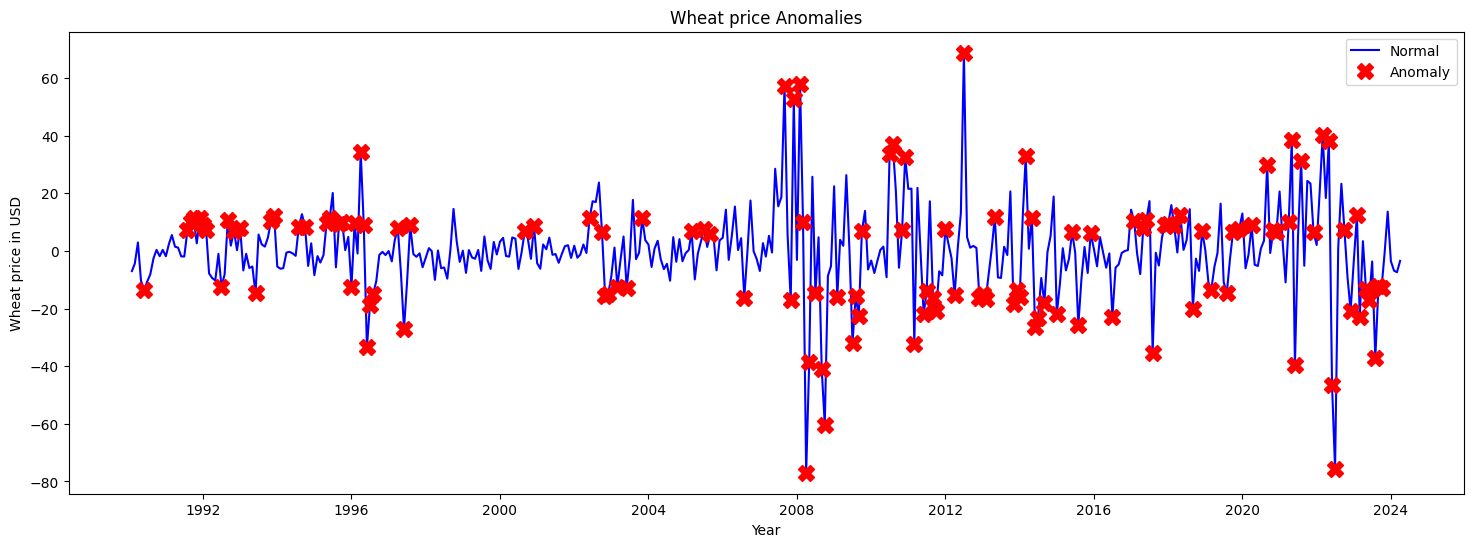

Anomalies detected:  123


In [183]:
# Plotting
distance = getDistanceBetweenPointsAndCentroid(data, kmeans)
data['anomaly2optimized'] = (distance >= best_threshold_distance).astype(int)
a = data[data['anomaly2optimized'] == 1]  # anomaly
plt.figure(figsize=(18, 6))
plt.plot(data['PWHEAMTUSDM'], color='blue', label='Normal')
plt.plot(a['PWHEAMTUSDM'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
plt.xlabel('Year')
plt.ylabel('Wheat price in USD')
plt.title('Wheat price Anomalies')
plt.legend(loc='best')
plt.show()
print('Anomalies detected: ', data['anomaly2optimized'][data['anomaly2optimized'] == 1].sum())

3.1. Isolation Forest

In [184]:
from sklearn.ensemble import IsolationForest

In [185]:
#this value has to be tuned
outliers_fractions = 0.2

model = IsolationForest(contamination=outliers_fractions)
model.fit(data.values)
data['anomaly3'] = model.predict(data.values)

Plotting

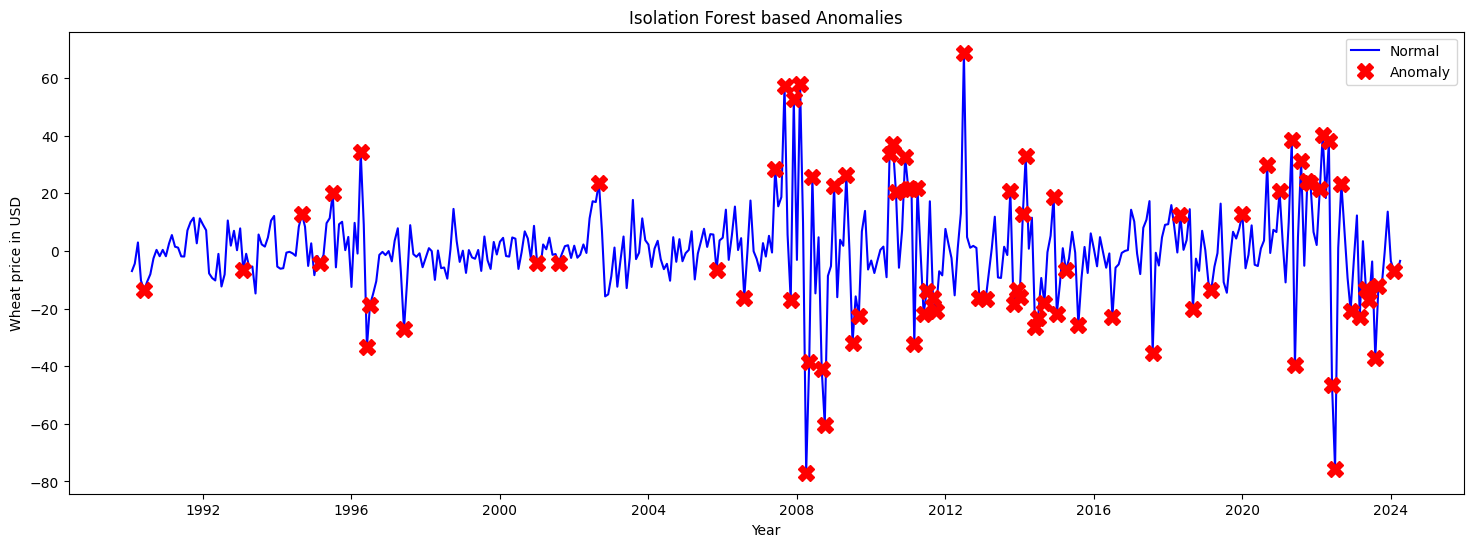

Anomalies detected:  82


In [186]:
data['anomaly3'] = pd.Series(data['anomaly3'].values, index=data.index)
a = data.loc[data['anomaly3'] == -1] #anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(data['PWHEAMTUSDM'], color='blue', label='Normal')
_ = plt.plot(a['PWHEAMTUSDM'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
_ = plt.xlabel('Year')
_ = plt.ylabel('Wheat price in USD')
_ = plt.title('Isolation Forest based Anomalies')
_ = plt.legend(loc='best')
plt.show()
print('Anomalies detected: ', -data['anomaly3'][data['anomaly3'] == -1].sum())


3.2. Isolation Forest with optimization

In [187]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

In [188]:
true_labels = np.zeros(len(data))
true_labels[np.random.choice(len(data), size=int(0.2 * len(data)), replace=False)] = 1

param_grid = {
    'n_estimators': [100, 200],
    'max_samples': ['auto', 0.8, 0.9],
    'contamination': [0.1, 0.15, 0.2],
    'max_features': [1.0, 0.8, 0.9]
}

if_model = IsolationForest()
grid_search = GridSearchCV(if_model, param_grid, cv=5, scoring=make_scorer(f1_score), n_jobs=-1)
grid_search.fit(data.values, true_labels)

print("Best parameters found: ", grid_search.best_params_)
best_if_model = grid_search.best_estimator_

data['anomaly3optimized'] = best_if_model.predict(data.values)



C:\Users\Micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best parameters found:  {'contamination': 0.1, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100}


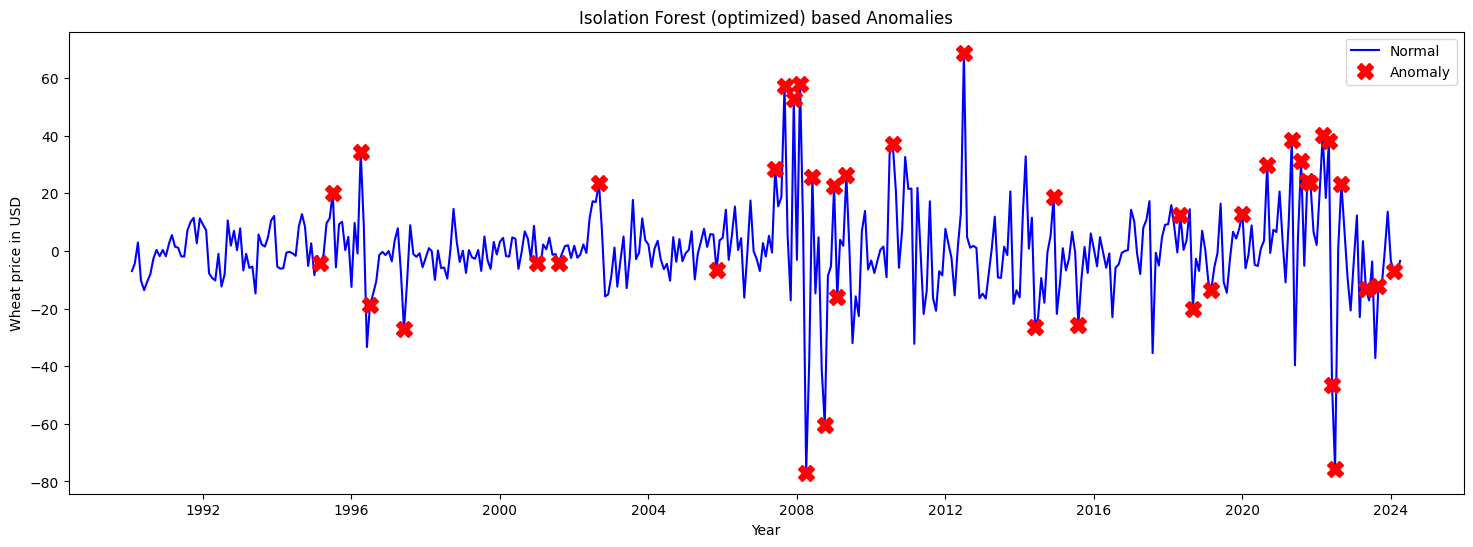

Anomalies detected:  41


In [189]:
# Plotting
data['anomaly3optimized'] = pd.Series(data['anomaly3optimized'].values, index=data.index)
a = data.loc[data['anomaly3optimized'] == -1] # anomaly
plt.figure(figsize=(18,6))
plt.plot(data['PWHEAMTUSDM'], color='blue', label='Normal')
plt.plot(a['PWHEAMTUSDM'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
plt.xlabel('Year')
plt.ylabel('Wheat price in USD')
plt.title('Isolation Forest (optimized) based Anomalies')
plt.legend(loc='best')
plt.show()
print('Anomalies detected: ', -data['anomaly3optimized'][data['anomaly3optimized'] == -1].sum())